In [17]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [ ]:
bag = rosbag.Bag('/home/uware/rosbags/_2022-02-21-11-12-03.bag')

# create variables
target = 'distance'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [0.5,1,1.5]

In [18]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [19]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance
0,0.000000,1.540828
1,0.100539,1.544104
2,0.190374,1.560746
3,0.282790,1.584294
4,0.378646,1.586674
...,...,...
566,26.838087,0.525557
567,26.873688,0.522651
568,26.908928,0.526820
569,26.945567,0.525514


<AxesSubplot:xlabel='relative_time'>

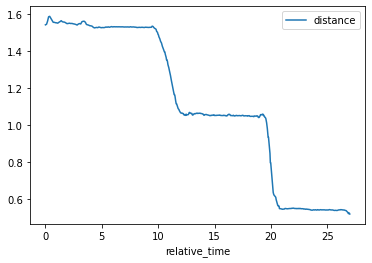

In [20]:
# initial graph
df.plot(x='relative_time', y=target)

In [21]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [22]:
# the amount of data points we are left with
len(x[peaks])

109

In [23]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance'>

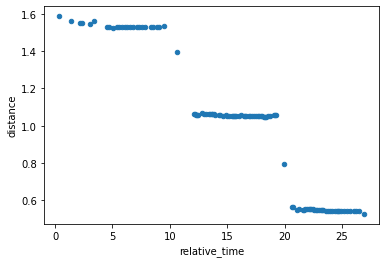

In [24]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [25]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance,true_distance
4,0.378646,1.586674,1.5
12,1.400859,1.563154,1.5
19,2.139101,1.549671,1.5
21,2.352607,1.548457,1.5
27,3.014134,1.547687,1.5
...,...,...,...
536,25.708680,0.541044,0.5
545,26.053868,0.543654,0.5
550,26.241443,0.544948,0.5
556,26.467707,0.542944,0.5


In [26]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [27]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [28]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance,true_distance,error
4,0.378646,1.586674,1.5,-0.086674
12,1.400859,1.563154,1.5,-0.063154
157,12.102720,1.065689,1.0,-0.065689
160,12.206111,1.062765,1.0,-0.062765
385,19.972546,0.796951,0.5,-0.296951
403,20.636167,0.566467,0.5,-0.066467


In [29]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
0.5,36.0,-0.054346,0.042084,-0.296951,-0.051031,-0.047168,-0.043681,-0.026820
1.0,47.0,-0.055744,0.005454,-0.068637,-0.059522,-0.053653,-0.051697,-0.047706
1.5,26.0,-0.031129,0.031308,-0.086674,-0.033097,-0.030110,-0.028340,0.104955


In [30]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

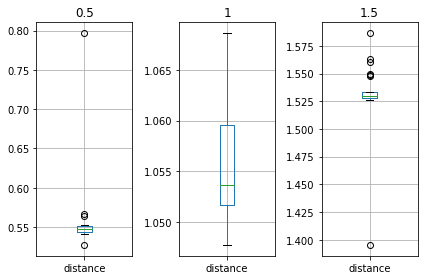

In [31]:
box_plotter(target)

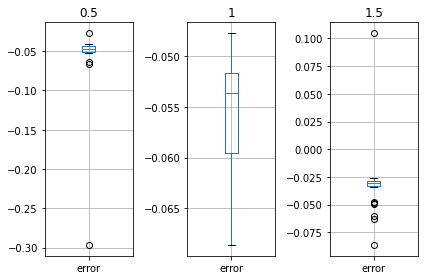

In [32]:
box_plotter('error')